# Expression Level of DEGs in 24h dNipBL mESCs and proximity to ChIP features

***Purpose:*** Plotting distance from promoter of DEGs to ChIP signal to see relationship between proximity of the chromatin-interacting proteins and differential expression.

* Cumulative portion of genes relative to TSS
* Concentration of CTCF peaks within a TAD compared to DEGs

In [51]:
import plotting_histogram_functions as pfn
import filter_gene_functions as flt

In [52]:
# ignore FutureWarnings generated by pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import bioframe as bf
from gtfparse import read_gtf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Load data and project files

- dNipbL dataset 
- ChIP .bed files

In [53]:
proj = "/project/fudenber_735/collaborations/karissa_2022/20220812_EA18-1_RNAseq-Analysis_forGeoff/"
# Importing day 1 depletion in ESCs DEGS
day1_sigRes = 'EA18.1_ESC_1d-depletion_DESeq2/20220817_EA18-1_resSig_ESC_1d-depletion.csv'
vst_normalized_counts = 'EA18.1_ESC_1d-depletion_DESeq2/20220817_EA18-1_ESC-1d_sf-normalized_vst-transformed.csv'
WT_samples = ['KHRNA1', 'KHRNA7', 'KHRNA13', 'KHRNA22', 'KHRNA23', 'KHRNA50']

# import results table and add normalized feature counts to label non-significant genes
day1_res_df = pd.read_csv(proj+day1_sigRes)
vst_counts_df = pd.read_csv(proj+vst_normalized_counts).rename(columns={'Unnamed: 0' : 'Geneid'})
vst_counts_df['avg_counts'] = vst_counts_df[WT_samples].mean(axis='columns')
day1_res_df = day1_res_df.merge(vst_counts_df[['Geneid', 'avg_counts']], how='outer')

# Getting TSSEs
tss_df = read_gtf("/project/fudenber_735/collaborations/karissa_2022/old/RNAseq/STAR_Gencode_alignment/tss_annotions_gencode.vM23.primary_assembly.gtf")
ts_intervals = flt.get_tss_gene_intervals(tss_df)

# labelling our dataset
day1_res_df = day1_res_df.merge(ts_intervals, left_on='Geneid', right_on='gene_id', how='left')

# If could not find a TSS, drop entire row
day1_res_df.dropna(subset=['start'], inplace=True)

# Remove any genes mapped to chrX before proceeding --> save these for later analysis
day1_res_df = day1_res_df[~day1_res_df.chrom.isin(['chrX'])]
day1_res_df = bf.sanitize_bedframe(day1_res_df)

INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'gene_type', 'gene_name', 'transcript_type', 'transcript_name', 'level', 'transcript_support_level', 'mgi_id', 'tag', 'havana_gene', 'havana_transcript', 'protein_id', 'ccdsid', 'ont']


In [54]:
# Add the differential expression status for filtering genes
day1_res_df = flt.label_DE_status(day1_res_df)

In [55]:
# Load Chip-Seq files 
chip_folder = "/project/fudenber_735/collaborations/karissa_2022/2022_09_features_for_RNAseq/ChIP-seq_in_WT-parental-E14/"

ctcf = "CTCF_peaks_called_on_4reps_foundInatLeast2reps_noBlacklist.bed"
rad21 = "RAD21_peaks_called_on_6reps_foundInatLeast3reps_noBlacklist.bed"
nipbl = "Nipbl_112.175.197.114.177.196_peaks.xls.bed"
promoter = "H3K27ac_EA92-97_peaks.xls.bed"

chip_peaks_condition_dict = {'CTCF' : chip_folder+ctcf, 'RAD21' : chip_folder+rad21,
                           'NIPBL' : chip_folder+nipbl, 'H3K27ac' : chip_folder+promoter}

### Annotate distance to ChIP peak



In [56]:
import importlib
importlib.reload(flt)

<module 'filter_gene_functions' from '/home1/pokorny/transcription_3Dfolding/transcription_3dfolding/transcription_data_analysis/filter_gene_functions.py'>

In [57]:
for (chip, file) in chip_peaks_condition_dict.items():
    peaks = flt.get_peak_bioframe(file)
    day1_res_df = flt.label_closest_peak(day1_res_df, peaks, chip)

In [61]:
day1_res_df.head(10)

,Geneid,SYMBOL,log2FoldChange,padj,baseMean,avg_counts,gene_id,chrom,start,end,DE_status,CTCF_distance,RAD21_distance,NIPBL_distance,H3K27ac_distance
0,ENSMUSG00000025128.7,Bhlhe22,-4.479336,4.277827e-03,7.794735,6.255218,ENSMUSG00000025128.7,chr3,18054173,18054173,down,1281,1121,23188,0
1,ENSMUSG00000051314.11,Ffar2,-3.910856,3.800000e-06,31.133503,6.711927,ENSMUSG00000051314.11,chr7,30823776,30823776,down,2965,2799,3164,2640
2,ENSMUSG00000057182.15,Scn3a,-3.806326,5.010000e-18,144.877936,8.010170,ENSMUSG00000057182.15,chr2,65567493,65567493,down,0,0,5632,295
3,ENSMUSG00000047495.15,Dlgap2,-3.530066,4.213601e-03,9.073752,6.361043,ENSMUSG00000047495.15,chr8,14095864,14095864,down,25808,25694,7379,44
4,ENSMUSG00000034310.8,Tmem132d,-3.518345,3.690000e-10,63.300332,7.357740,ENSMUSG00000034310.8,chr5,128433078,128433078,down,1,0,30282,737
5,ENSMUSG00000053765.4,Oas1f,-3.317824,1.260000e-05,21.720049,6.534978,ENSMUSG00000053765.4,chr5,120847366,120847366,down,6547,6706,48137,176
6,ENSMUSG00000096014.1,Sox1,-3.105280,8.640000e-18,148.693291,8.010320,ENSMUSG00000096014.1,chr8,12395294,12395294,down,2511,11348,9539,1375
7,ENSMUSG00000037035.5,Inhbb,-3.102359,3.230000e-40,720.378623,9.707031,ENSMUSG00000037035.5,chr1,119422249,119422249,down,0,0,3321,296
9,ENSMUSG00000022661.14,Cd200,-2.992487,5.652550e-04,17.368537,6.451764,ENSMUSG00000022661.14,chr16,45409054,45409054,down,0,0,175261,162531
10,ENSMUSG00000064325.4,Hhip,-2.964982,4.990000e-05,25.861688,6.711663,ENSMUSG00000064325.4,chr8,79990350,79990350,down,439,0,18395,0


In [73]:
import importlib
importlib.reload(pfn)

<module 'plotting_histogram_functions' from '/home1/pokorny/transcription_3Dfolding/transcription_3dfolding/transcription_data_analysis/plotting_histogram_functions.py'>

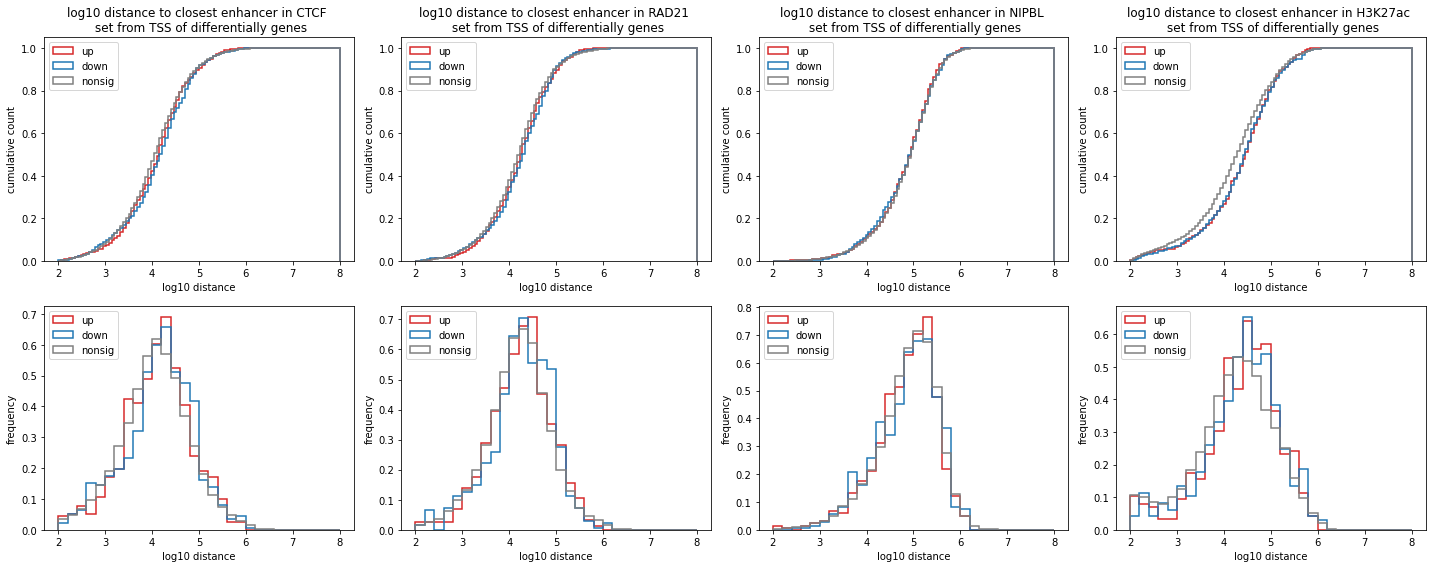

In [74]:
fig, axs = plt.subplots(2, len(chip_peaks_condition_dict), figsize=(20, 8))

for (chip_name, file), axi in zip(chip_peaks_condition_dict.items(), np.arange(axs.shape[1])):
    pfn.plot_distance_histogram(day1_res_df, 
                                 chip_name+'_distance', 
                                 ax=axs[0, axi],
                                 cumulative=True,
                                 bins=100,
                                 plot_title='log10 distance to closest enhancer in {} \n set from TSS of differentially genes'.format(chip_name))
    
    pfn.plot_distance_histogram(day1_res_df, 
                                chip_name+'_distance', 
                                ax=axs[1, axi],
                                bins=30)
    
plt.tight_layout()
plt.show()

# Concentration of CTCF within TADs of DEG

In [81]:
feature_dir = '/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/features'
insulation_table = pd.read_table(feature_dir+'/bonev2017.HiC_ES.mm10.mapq_30.1000.window_200000.insulation')

In [82]:
quantiled_df = day1_res_df.copy()

quantiled_df = flt.label_quantiles(quantiled_df, quantile_value_col="avg_counts")
quantiled_df = flt.label_quantiles(quantiled_df, quantile_value_col="avg_counts", label_subset='up')
quantiled_df = flt.label_quantiles(quantiled_df, quantile_value_col="avg_counts", label_subset='down')

In [83]:
category_colormap_big = {'up_0.0-0.5' : '#fee5d9',
                         'up_0.5-0.75' : '#fcae91',
                         'up_0.75-0.95' : '#fb6a4a',
                         'up_0.95-1.0' : '#cb181d',

                         'down_0.5-0.75' : '#bdd7e7',
                         'down_0.75-0.95' : '#6baed6',
                         'down_0.95-1.0' : '#2171b5',

                         'nonsig_0.0-0.5' : '#d9d9d9',
                         'nonsig_0.5-0.75' : '#bdbdbd',
                         'nonsig_0.75-0.95' : '#969696',
                         'nonsig_0.95-1.0' : '#636363'
                        }

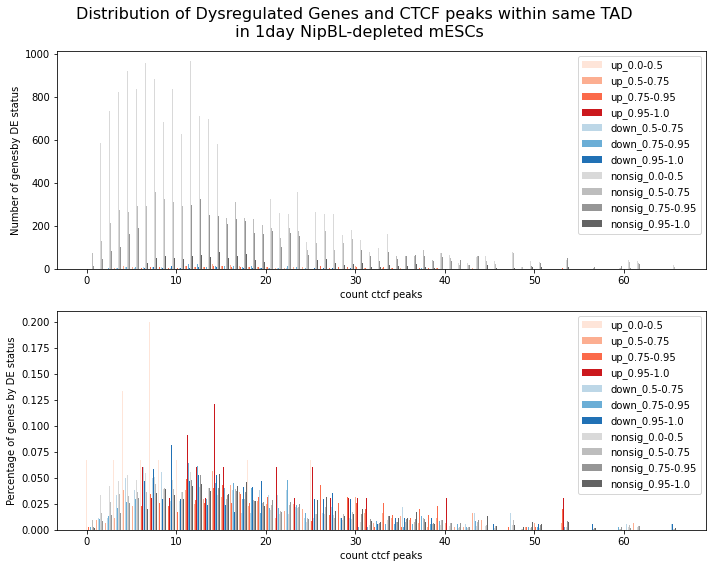

In [88]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
fig.suptitle(('Distribution of Dysregulated Genes and '
             'CTCF peaks within same TAD \n in 1day NipBL-depleted mESCs'),
             fontsize=16)

# Defining TADs using midpoints between boundaries
tad_mid_df = flt.tad_windows_from_boundaries(insulation_table, take_midpoint=True)

# Annotate number of CTCF within the tad
df = tad_mid_df.copy()
ctcf_df = flt.get_peak_bioframe(chip_peaks_condition_dict['CTCF'])
df['count_ctcf_peaks'] = bf.count_overlaps(df, ctcf_df)['count']

pfn.group_features_by_region(df,
                             quantiled_df,
                             feature_category_colors=category_colormap_big,
                             region_group_col='count_ctcf_peaks',
                             ax=axs[0]
                            )

pfn.distribution_features_by_region(df,
                                    quantiled_df,
                                    feature_category_colors=category_colormap_big,
                                    region_group_col='count_ctcf_peaks',
                                    ax=axs[1]
                                   )
    
plt.tight_layout()
plt.show()

Grouping into bins to see a little better :D 

In [ ]:
# assigning 'bins' as categories, where 0-5 --> assigned 0, 5-10 --> assigned 5

In [93]:
bin_edges = np.arange(0, 70, 5)

In [94]:
bin_edges

array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65])

In [96]:
prev = None

In [111]:
for i in bin_edges:
    if prev == None:
        prev = i
        continue
        
    bin_ix = (df['count_ctcf_peaks'] >= prev) & (df['count_ctcf_peaks'] < i)
    df.loc[bin_ix, 'count_ctcf_bin'] = prev
    
    prev = i

In [120]:
df['count_ctcf_bin'].value_counts()

0.0     1581
5.0     1320
10.0     837
15.0     442
20.0     218
25.0     154
30.0      67
35.0      45
40.0      26
45.0      13
50.0       9
60.0       4
55.0       2
Name: count_ctcf_bin, dtype: int64

In [123]:
import importlib
importlib.reload(pfn)

<module 'plotting_histogram_functions' from '/home1/pokorny/transcription_3Dfolding/transcription_3dfolding/transcription_data_analysis/plotting_histogram_functions.py'>

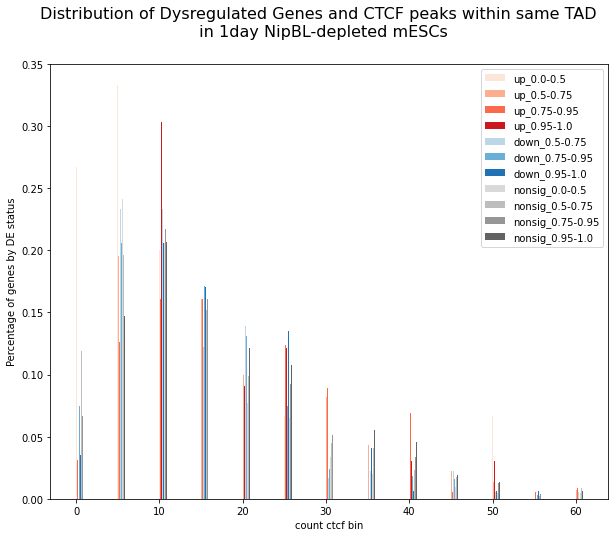

In [124]:
fig, axs = plt.subplots(1, 1, figsize=(10, 8))
fig.suptitle(('Distribution of Dysregulated Genes and '
             'CTCF peaks within same TAD \n in 1day NipBL-depleted mESCs'),
             fontsize=16)

pfn.distribution_features_by_region(df,
                                    quantiled_df,
                                    feature_category_colors=category_colormap_big,
                                    region_group_col='count_ctcf_bin',
                                    ax=axs
                                   )